<a href="https://colab.research.google.com/github/suarez-duran-m/personal_projects/blob/main/movility/medellin/analysis_accidents_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysing Medellín car accident report

In [ ]:
import folium, re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
from IPython.display import Image

In [ ]:
data = pd.read_csv('crashes_georef_2020_to_2022.csv')

In [ ]:
data.head()

,HORA,DIA_NOMBRE,PERIODO,CLASE,DIRECCION,TIPO_GEOCOD,GRAVEDAD,DISENO,MES,DIA,FECHA,MES_NOMBRE,LONGITUD,LATITUD
0,01:35:00,MIÉRCOLES,2020,Choque,CL 10 A CR 41,Malla vial,CON HERIDOS,Tramo de via,7,1,2020/07/01 00:00:00+00,JULIO,-75.568507,6.210703
1,11:30:00,VIERNES,2020,Choque,CR 38 CL 49 A,Malla vial,SOLO DAÑOS,Tramo de via,5,8,2020/05/08 00:00:00+00,MAYO,-75.558959,6.244545
2,08:25:00,LUNES,2020,Otro,CR 57 CL 51,Malla vial,SOLO DAÑOS,Tramo de via,10,19,2020/10/19 00:00:00+00,OCTUBRE,-75.575041,6.253081
3,06:30:00,MIÉRCOLES,2020,Choque,CL 5 CR 47,No Ubicada,CON HERIDOS,Interseccion,7,15,2020/07/15 00:00:00+00,JULIO,-75.703816,6.221806
4,02:00:00,DOMINGO,2020,Choque,CR 62 CL 50,Malla vial,CON HERIDOS,Tramo de via,4,5,2020/04/05 00:00:00+00,ABRIL,-75.576423,6.253848


In [ ]:
data.describe()

,PERIODO,MES,DIA,LONGITUD,LATITUD
count,95916.000000,95916.000000,95916.000000,95916.000000,95916.000000
mean,2020.914894,6.024501,15.627288,-75.587260,6.249369
std,0.754643,3.452193,8.689897,0.040368,0.028340
min,2020.000000,1.000000,1.000000,-75.703816,6.166775
25%,2020.000000,3.000000,8.000000,-75.593084,6.227359
50%,2021.000000,6.000000,16.000000,-75.575648,6.249114
75%,2021.000000,9.000000,23.000000,-75.564802,6.271089
max,2022.000000,12.000000,31.000000,-75.490257,6.368358


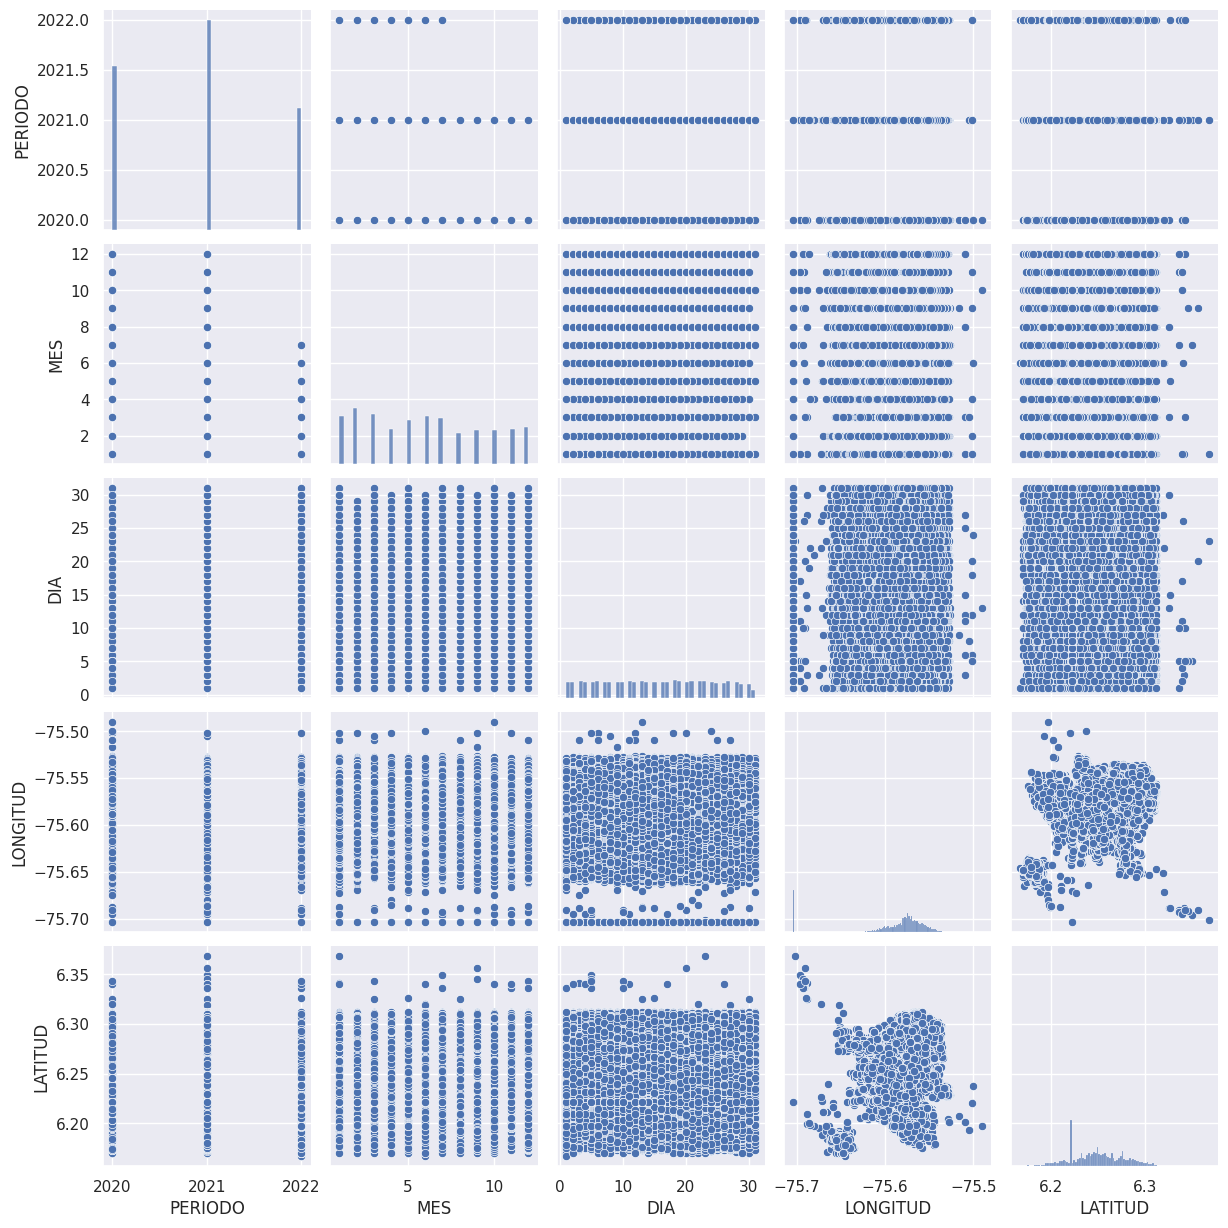

In [ ]:
#cols = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt', 'SalePrice']
sns.set()
sns.pairplot(data)

<ipython-input-6-e616efc2bbef>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = data.corr()


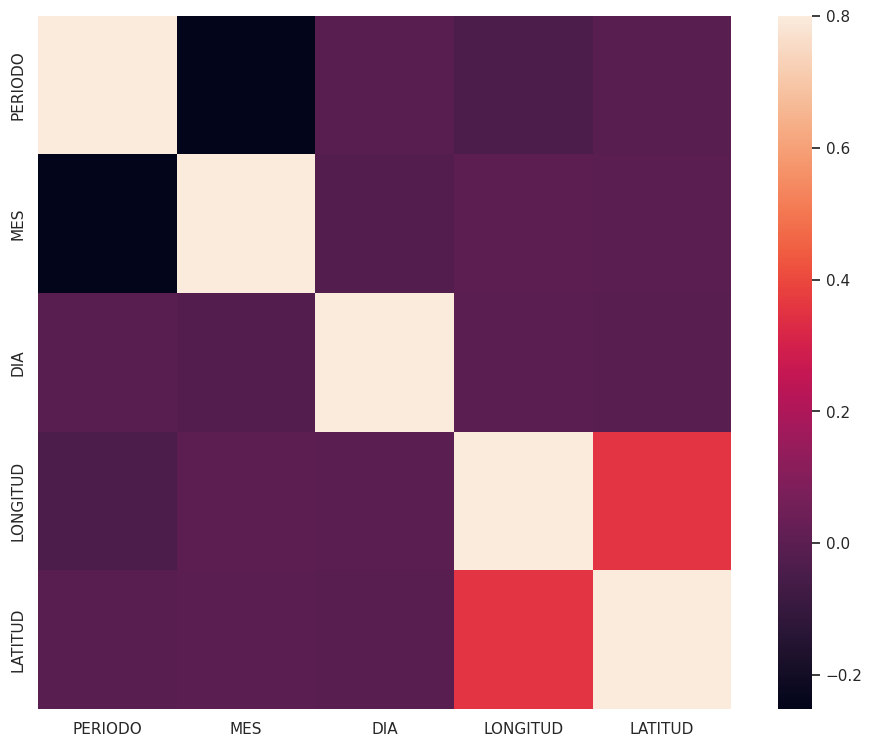

In [ ]:
#correlation matrix
corrmat = data.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

In [ ]:
tmp_df = data[['LATITUD', 'LONGITUD']].copy()

tmp_df['LATITUD'] *= 1e4
tmp_df['LONGITUD'] *= 1e4
tmp_df['LATITUD'] = tmp_df['LATITUD'].astype(int)
tmp_df['LONGITUD'] = tmp_df['LONGITUD'].astype(int)

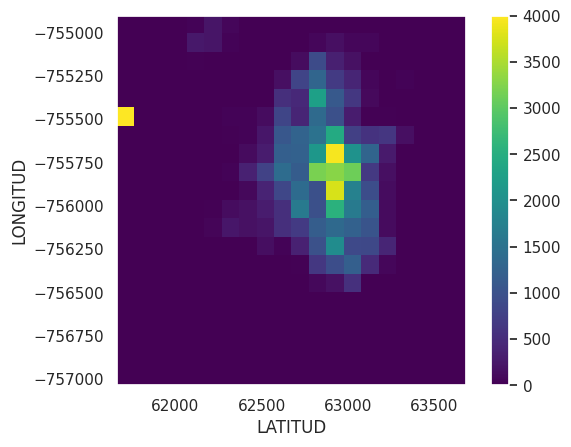

In [ ]:
# Create a 2D histogram
hist, x_edges, y_edges = np.histogram2d(tmp_df['LATITUD'].values, tmp_df['LONGITUD'].values, bins=(20, 20))

# Plot the 2D histogram
plt.imshow(hist, interpolation='nearest', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], vmin=0., vmax=4e3, cmap='viridis') #, norm=LogNorm(vmin=1., vmax=9e3))

plt.colorbar()
plt.xlabel('LATITUD')
plt.ylabel('LONGITUD')
plt.grid(False)

plt.show()

In [ ]:
highest = []

for i in range(20):
  for j in range(20):
    if hist[i, j] > 2.0e3:
      highest.append([i, j, hist[i, j]])
      print(i, j, hist[i, j])

4 11 2275.0
5 0 8251.0
6 12 2452.0
7 11 2119.0
7 12 3940.0
7 13 2036.0
8 11 3202.0
8 12 3292.0
8 13 3117.0
9 12 3764.0
10 12 2558.0


In [ ]:
highest = np.array(highest)

sorted_indices = np.argsort(highest[:, 2])
sorted_data = highest[sorted_indices][::-1]
sorted_data

array([[5.000e+00, 0.000e+00, 8.251e+03],
       [7.000e+00, 1.200e+01, 3.940e+03],
       [9.000e+00, 1.200e+01, 3.764e+03],
       [8.000e+00, 1.200e+01, 3.292e+03],
       [8.000e+00, 1.100e+01, 3.202e+03],
       [8.000e+00, 1.300e+01, 3.117e+03],
       [1.000e+01, 1.200e+01, 2.558e+03],
       [6.000e+00, 1.200e+01, 2.452e+03],
       [4.000e+00, 1.100e+01, 2.275e+03],
       [7.000e+00, 1.100e+01, 2.119e+03],
       [7.000e+00, 1.300e+01, 2.036e+03]])

In [ ]:
print(x_edges[5], y_edges[0], hist[5, 0])
print(x_edges[7], y_edges[12], hist[7, 12])
print(x_edges[9], y_edges[12], hist[9, 12])
print(x_edges[8], y_edges[12], hist[8, 12])
print(x_edges[8], y_edges[11], hist[8, 11])
print(x_edges[8], y_edges[13], hist[8, 13])
print(x_edges[10], y_edges[12], hist[10, 12])
print(x_edges[6], y_edges[12], hist[6, 12])
print(x_edges[4], y_edges[11], hist[4, 11])
print(x_edges[7], y_edges[11], hist[7, 11])
print(x_edges[7], y_edges[13], hist[7, 13])

62171.0 -757038.0 8251.0
62372.6 -755756.4 3940.0
62574.2 -755756.4 3764.0
62473.4 -755756.4 3292.0
62473.4 -755863.2 3202.0
62473.4 -755649.6 3117.0
62675.0 -755756.4 2558.0
62271.8 -755756.4 2452.0
62070.2 -755863.2 2275.0
62372.6 -755863.2 2119.0
62372.6 -755649.6 2036.0


In [ ]:
# Create a map centered on a specific location
map = folium.Map(location=[data['LATITUD'].mean(), data['LONGITUD'].mean()], zoom_start=14)

# Add markers for each event

for i in sorted_data:
  if int(i[0]) == 7 and int(i[1]) == 12:
    folium.Marker(location=[x_edges[int(i[0])]/1e4, y_edges[int(i[1])]/1e4], popup=f"Number accidents: {i[2]}",
                  icon=folium.Icon(color='red', icon='info-sign')
                  ).add_to(map)

  else:
    folium.Marker(location=[x_edges[int(i[0])]/1e4, y_edges[int(i[1])]/1e4], popup=f"Number accidents: {i[2]}",
                  icon=folium.Icon(color='blue', icon='info-sign')
                  ).add_to(map)
map